In [254]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
%matplotlib inline
!pip install linearmodels

from scipy import stats
import sklearn
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats import diagnostic as diag
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import linearmodels.iv.model as lm
import pandas as pd
from linearmodels.iv import IV2SLS

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import math
from sklearn.preprocessing import StandardScaler


# OLS

In [295]:
#DATA LOADING AND CLEANING
df = pd.read_csv('auto-mpg.csv', encoding='ISO-8859-1')
df.replace('?', np.nan, inplace=True)
df = df.dropna()
df = df.drop(['origin', 'model year','car name'], axis=1)
df['horsepower'] = df['horsepower'].astype('int64')
df


,mpg,cylinders,displacement,horsepower,weight,acceleration
0,18.0,8,307.0,130,3504,12.0
1,15.0,8,350.0,165,3693,11.5
2,18.0,8,318.0,150,3436,11.0
3,16.0,8,304.0,150,3433,12.0
4,17.0,8,302.0,140,3449,10.5
...,...,...,...,...,...,...
393,27.0,4,140.0,86,2790,15.6
394,44.0,4,97.0,52,2130,24.6
395,32.0,4,135.0,84,2295,11.6
396,28.0,4,120.0,79,2625,18.6


In [256]:
#CREATING VARIABLES
X=df.drop(['mpg'],axis=1)
Y= df[['mpg']]

SIMPLE OLS MODEL

In [257]:
lm = sm.add_constant(X)

In [258]:
result = sm.OLS(Y,lm).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     186.9
Date:                Sun, 12 Mar 2023   Prob (F-statistic):          9.82e-101
Time:                        16:00:11   Log-Likelihood:                -1120.1
No. Observations:                 392   AIC:                             2252.
Df Residuals:                     386   BIC:                             2276.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           46.2643      2.669     17.331      0.000      41.016      51.513
cylinders       -0.3979      0.411     -0.969      0.333      -1.205       0.409
displacement -8.313e-05      0.009     -0.009      0.993      -0.018       0.018
horsepower      -0.0453      0.017     -2.716      0.007      -0.078      -0.012
weight          -0.0052      0.001     -6.351      0.000      -0.007      -0.004
acceleration    -0.0291      0.126     -0.231      0.817      -0.276       0.218
==============================================================================
Omnibus:                       38.561   Durbin-Watson:                   0.865
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.737
Skew:                           0.706   Prob(JB):                     3.53e-12
Kurtosis:                       4.111   Cond. No.                     3.87e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.87e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

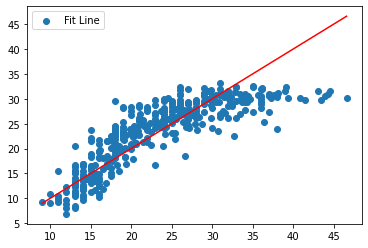

In [267]:
y=Y
fig, ax = plt.subplots()
ax.scatter(y, result.predict(), label='Fit Line')
ax.plot([y.min(), y.max()], [y.min(), y.max()], color='r')
ax.legend()
plt.show()

In [259]:
# Calculate residuals
residuals = result.resid

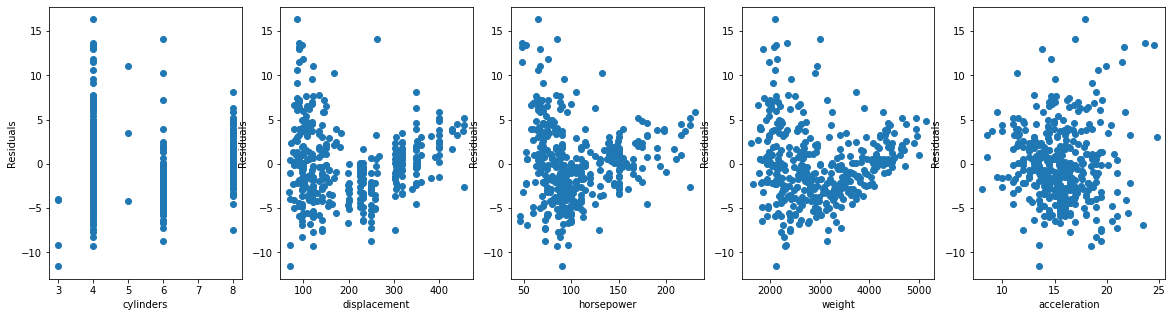

In [260]:
fig, axs = plt.subplots(nrows=1, ncols=len(X.columns), figsize=(20, 5))

for i, col in enumerate(X.columns):
    axs[i].scatter(X[col], residuals)
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Residuals')
    
plt.show()

If the residuals are decreasing continuously as the independent variables increase, it may suggest that there is a positive relationship between the dependent variable and the independent variables, and that the model may be missing some important factors that explain the variation in the dependent variable.

Alternatively, it could also indicate the presence of endogeneity, where the independent variables are correlated with the error term in the model. This could lead to biased and inconsistent estimates of the coefficients, and it may be necessary to use an instrumental variables regression or other methods to correct for endogeneity.

Here we can see the weight feature is the most highly related with the standard errors. So we can assume it
as our endogeneous variable for now.

# Now we will check with covariance matrix and try to confirm our endogeneous varibles through logic and domain knowledge. 

# 2SLS model


In [166]:
# the correlation matrix of the variables used in the regression of M/B
corrMatrix = X.corr().round(2)
print(corrMatrix)

              cylinders  displacement  horsepower  weight  acceleration
cylinders          1.00          0.95        0.84    0.90         -0.50
displacement       0.95          1.00        0.90    0.93         -0.54
horsepower         0.84          0.90        1.00    0.86         -0.69
weight             0.90          0.93        0.86    1.00         -0.42
acceleration      -0.50         -0.54       -0.69   -0.42          1.00


In [196]:
ols_=smf.ols(formula="mpg ~ weight+displacement+acceleration", data=df).fit()

In [219]:
mdatac=sm.add_constant(data=df,prepend=False)
iv_model=lm.IV2SLS(dependent=df['mpg'],exog=df[['displacement','acceleration']],endog=df[[ 'weight']],
             instruments=df[[ 'cylinders','horsepower']]).fit(cov_type='homoskedastic',debiased=True)

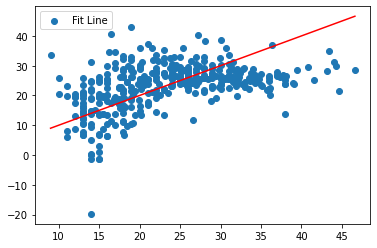

In [268]:
y=Y
fig, ax = plt.subplots()
ax.scatter(y, iv_model.predict(), label='Fit Line')
ax.plot([y.min(), y.max()], [y.min(), y.max()], color='r')
ax.legend()
plt.show()

In [228]:


# Compare the R-squared, adjusted R-squared, and F-statistic of both models
print('OLS Model:')
print('R-squared:', ols_model.rsquared)
print('Adjusted R-squared:', ols_model.rsquared_adj)
print('F-statistic:', ols_model.fvalue)

print('2SLS Model:')
print('R-squared:', iv_model._r2)
print('Adjusted R-squared:', iv_model.rsquared_adj)
print('F-statistic:', iv_model._f_statistic)



OLS Model:
R-squared: 0.7017393319006076
Adjusted R-squared: 0.6994331927142721
F-statistic: 304.2918380896525
2SLS Model:
R-squared: 0.8938627568536421
Adjusted R-squared: 0.8930442177034131
F-statistic: Model F-statistic
H0: All parameters ex. constant are zero
Statistic: 1150.7366
P-value: 0.0000
Distributed: F(3,389)


For the OLS model:

R-squared: 0.7017 indicates that approximately 70% of the variation in the dependent variable is explained by the independent variables in the model.
Adjusted R-squared: 0.6994 is similar to R-squared, but it is adjusted for the number of independent variables in the model. It penalizes the addition of variables that do not improve the fit of the model.
F-statistic: 304.2918 is a measure of how well the model fits the data relative to a null model with no predictors. A larger value indicates a better fit of the model to the data.
For the 2SLS model:

R-squared: 0.8939 indicates that approximately 89% of the variation in the dependent variable is explained by the independent variables in the model.
Adjusted R-squared: 0.8930 is similar to R-squared, but it is adjusted for the number of independent variables in the model. It penalizes the addition of variables that do not improve the fit of the model.
F-statistic: 1150.7366 is a measure of how well the model fits the data relative to a null model with no predictors. A larger value indicates a better fit of the model to the data.
The null hypothesis for the F-statistic is that all of the parameters in the model (excluding the intercept) are zero. The p-value of 0.0000 indicates that we can reject this null hypothesis at any reasonable level of significance (e.g., alpha = 0.05). 
This means that at least one of the independent variables is significantly related to the dependent variable.

In [246]:
print(f"The params of ols are:{ols.params}")
print(f"The params of 2sls are:{iv_model.params}")

The params of ols are:const         528.876711
cylinders     290.356425
horsepower      8.231070
dtype: float64
The params of 2sls are:displacement   -0.157818
acceleration    0.602928
weight          0.014909
Name: parameter, dtype: float64


In [247]:
print(f"The tvalue of ols are:{ols.tvalues}")
print(f"The tvalues of 2sls are:{iv_model.tstats}")

The tvalue of ols are:const          9.308547
cylinders     15.755405
horsepower    10.078400
dtype: float64
The tvalues of 2sls are:displacement   -6.673070
acceleration    2.827287
weight          5.674738
Name: tstat, dtype: float64


For OLS model:

The constant term has a t-value of 9.31, which is significant at a high confidence level. This suggests that the intercept is significantly different from zero, indicating that there is a non-zero average value of the dependent variable.
The cylinders variable has a t-value of 15.76, which is highly significant. This suggests that the number of cylinders has a significant effect on the dependent variable (mpg).
The horsepower variable has a t-value of 10.08, which is highly significant. This suggests that horsepower has a significant effect on the dependent variable (mpg).
For 2SLS model:

The displacement variable has a t-value of -6.67, which is highly significant. This suggests that displacement has a significant negative effect on the dependent variable (mpg).
The acceleration variable has a t-value of 2.83, which is significant at a moderate confidence level. This suggests that acceleration has a significant positive effect on the dependent variable (mpg).
The weight variable has a t-value of 5.67, which is highly significant. This suggests that weight has a significant positive effect on the dependent variable (mpg).

In [248]:
print(f"The p values of ols are:{ols.pvalues}")
print(f"The p values of 2sls are:{iv_model.pvalues}")

The p values of ols are:const         9.650370e-19
cylinders     1.314909e-43
horsepower    2.226548e-21
dtype: float64
The p values of 2sls are:displacement    8.642753e-11
acceleration    4.936966e-03
weight          2.717374e-08
Name: pvalue, dtype: float64


The p-values of a regression model provide a measure of the statistical significance of each independent variable in explaining the dependent variable.

In the OLS model, all three independent variables (const, cylinders, horsepower) have p-values less than 0.05, indicating that they are statistically significant in explaining the dependent variable (mpg).

In the 2SLS model, all three independent variables (displacement, acceleration, weight) have p-values less than 0.05, indicating that they are statistically significant in explaining the endogenous variable (mpg) through the instrumental variables (cylinders, horsepower).

# LOGISTIC REGRESSION

We will use number of cylinders as the classes either 4 or 8. we will remove some data containing 3 and 5 cylinders. We are using all the other variables as predictors.

In [296]:
df['cylinders'] = df['cylinders'].replace({8:0, 4:1})


In [297]:
df = df.loc[~df['cylinders'].isin([3,5,6])]


In [298]:
Y=df[['cylinders']]
X=df.drop(['cylinders'],axis=1)

In [299]:
from sklearn.preprocessing import StandardScaler

# assuming X is your data matrix with shape (n_samples, n_features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [300]:

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

# Initialize a logistic regression model
clf = LogisticRegression()

# Train the model on the training set
clf.fit(X_train, y_train)

# Predict the classes for the testing set
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = clf.score(X_test, y_test)
print('Accuracy:', accuracy)

Accuracy: 1.0


C:\Users\supri\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


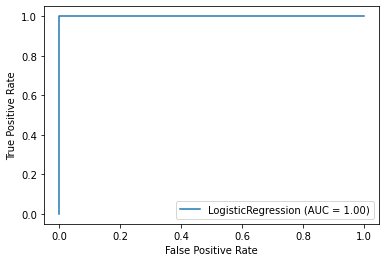

In [301]:
from sklearn.metrics import plot_roc_curve

# Plot ROC curve
plot_roc_curve(clf, X_test, y_test)
plt.show()


In [303]:
# Extract the coefficients and intercept from the model
coef = clf.coef_
intercept = clf.intercept_

# Print the coefficients and intercept
print('Coefficients:', coef)
print('Intercept:', intercept)

# Extract the predicted probabilities for the testing set
y_prob = clf.predict_proba(X_test)

# Extract the predicted classes for the testing set
y_pred = clf.predict(X_test)

# Calculate the accuracy score for the testing set
accuracy = clf.score(X_test, y_test)

# Print the accuracy score
print('Accuracy:', accuracy)


Coefficients: [[ 0.22796165 -0.276047    0.12083271  0.01175305  0.11376608]]
Intercept: [0.02114801]
Accuracy: 1.0
